# Using regression to predict house prices in Ames Iowa
Firstly, importing all necessary packages needed and setting some plot style preferences.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = (21.0, 13.0)
plt.rcParams['font.size'] = 18.0
sns.set_style('darkgrid')
sns.set_palette('pastel')

Then we can import all of the given data. We will consider splitting the data into the training set and validation set after some data cleaning and processing is completed.

In [3]:
full_data = pd.read_csv('./train.csv')

Next we can consider getting an overview of the recorded variables present in the data. We will also be able to identify the label of the variable we are trying to predict relating to the selling price of the house.

In [4]:
full_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

We can already see one irrelevant variable that we can throw out, the $\texttt{Id}$ variable which is just doubling up on our usual pandas indexing. So we can remove this and update the dataframe.

In [5]:
full_data = full_data.drop('Id', axis = 1)

If we need to refer to how each of these variables has been labelled and recorded we can refer to [data_description.txt](https://github.com/HStuklis/my-projects/blob/master/house-prices/data_description.txt). So we can see that we are trying to predict the value of $\texttt{SalePrice}$ based on the other 80 recorded variables. Before we get into the details of which type of regression we plan to use to do this we need to check whether we have any missing values present in our data. A great way to get an idea of the prevalence of missing data is by count the number of missing data by column and divide each by the total number of recorded data. This gives us the proportion of missing data by column label. We can then treat each case seperately to ensure coherence in the data. 

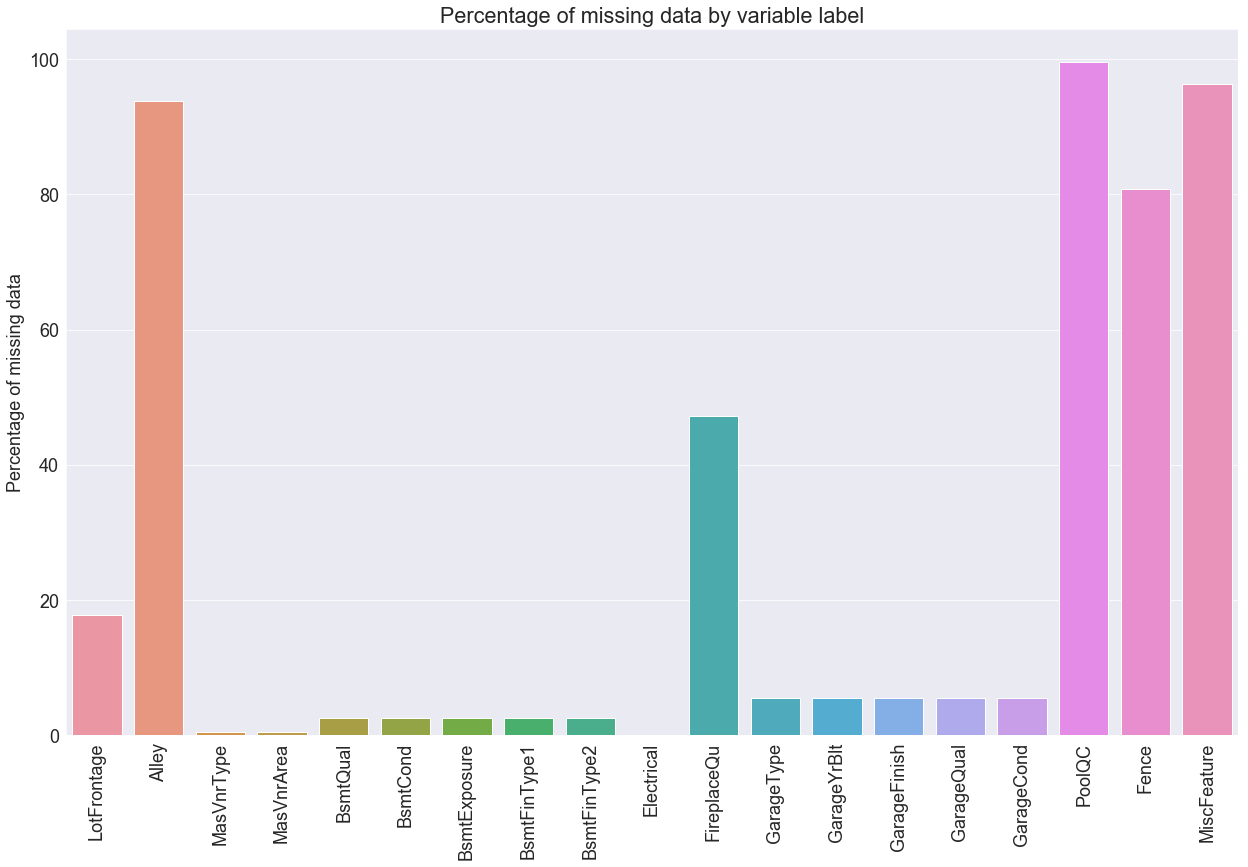

In [6]:
missing_count = full_data.isnull().sum()/len(full_data)
sns.barplot(x = missing_count[missing_count != 0].index, y = missing_count[missing_count != 0]*100)
plt.title('Percentage of missing data by variable label')
plt.ylabel('Percentage of missing data')
plt.xticks(rotation = 90);

Now we can go from left to right on this graph and treat each case of missing data. Firstly, for $\texttt{LotFrontage}$ it seems reasonable to ensure that properties that do not have a recorded lot frontage value have the least amount of impact on the regression mode. I think that filling these missing values with the median value of lot frontage would be the best option as it would ensure that these missing values do not skew the regression too much.

In [7]:
full_data.LotFrontage.fillna(full_data.LotFrontage.median(), inplace = True)

As for $\texttt{Alley}$ we can check the reason for all the missing values by finding the counts for each level of the categorical variable.

In [8]:
full_data.Alley.value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

So we can see that python has taken the recorded 'NA' value as described in [data_description.txt](https://github.com/HStuklis/my-projects/blob/master/house-prices/data_description.txt) as meaning the python reserved 'NA'. We can fix this by replacing each of the 'NA' values in the alley variable with 'NoA'.

In [9]:
full_data.Alley.fillna('NoA', inplace = True)

Similarly for $\texttt{MasVnrType}$ we can check the counts.

In [10]:
full_data.MasVnrType.value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

Once again python has taken the recorded 'None' as 'NA' so we can replace 'NA' with 'NoMV'.

In [11]:
full_data.MasVnrType.fillna('NoMV', inplace = True)

Now for $\texttt{MasVnrArea}$ we can assume that the missing values imply there is no masonry veneer. So we can just fill each with zero value. 

In [12]:
full_data.MasVnrArea.fillna(0, inplace = True)

Now for all of the $\texttt{Bsmt}$ variables we can assume that once again python has taken the reserved 'NA' value for each so we can replace all with 'NoB' representing no basement.

In [13]:
for i in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    full_data[i].fillna('NoB', inplace = True)

We can also assume the same is true for all of the $\texttt{Garage}$ variables (except $\texttt{GarageYrBlt}$ which represents a year so we replace with zero value instead). So we replace 'NA' with 'NoG' representing no garage.

In [14]:
for i in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType2'):
    full_data[i].fillna('NoG', inplace = True)
full_data.GarageYrBlt.fillna(0, inplace = True)

Now for $\texttt{Electrical}$ we can replace the missing value with the most common value to reduce the skew it will have on the regression.

In [15]:
full_data.Electrical.fillna(full_data.Electrical.mode()[0], inplace = True)

Now for $\texttt{FireplaceQu}$ we can again replace 'NA' with 'NoF', for $\texttt{PoolQC}$ we can replace 'NA' with 'NoP', for $\texttt{Fence}$ we can replace 'NA' with 'NoF' and for $\texttt{MiscFeature}$ we can replace 'NA' with 'NoM'.

In [16]:
full_data.FireplaceQu.fillna('NoF', inplace = True)
full_data.PoolQC.fillna('Nop', inplace = True)
full_data.Fence.fillna('NoF', inplace = True)
full_data.MiscFeature.fillna('NoM', inplace = True)

Now that we have treated all of the missing values we can consider changing some of the labelled variable types. We can note in [data_description.txt](https://github.com/HStuklis/my-projects/blob/master/house-prices/data_description.txt) that $\texttt{MSSubClass}$, $\texttt{OverallQual}$, $\texttt{OverallCond}$, $\texttt{YrSold}$ and $\texttt{MoSold}$ should all be treated as categorical variables if they are not already. We can ensure this is the case by setting all data types of these columns to object which all of the other categorical variables have.

In [17]:
for i in ('MSSubClass', 'OverallQual', 'OverallCond', 'YrSold', 'MoSold'):
    full_data[i] = full_data[i].astype(object)

Now we can consider log one plus transforming the rest of the numerical variables to fit a better regression model. As log one plus transforming will approximately normalise the skewed data and leave the unskewed data largely unchanged. We can see this by first observing the distribution of all of the numerical variables present.

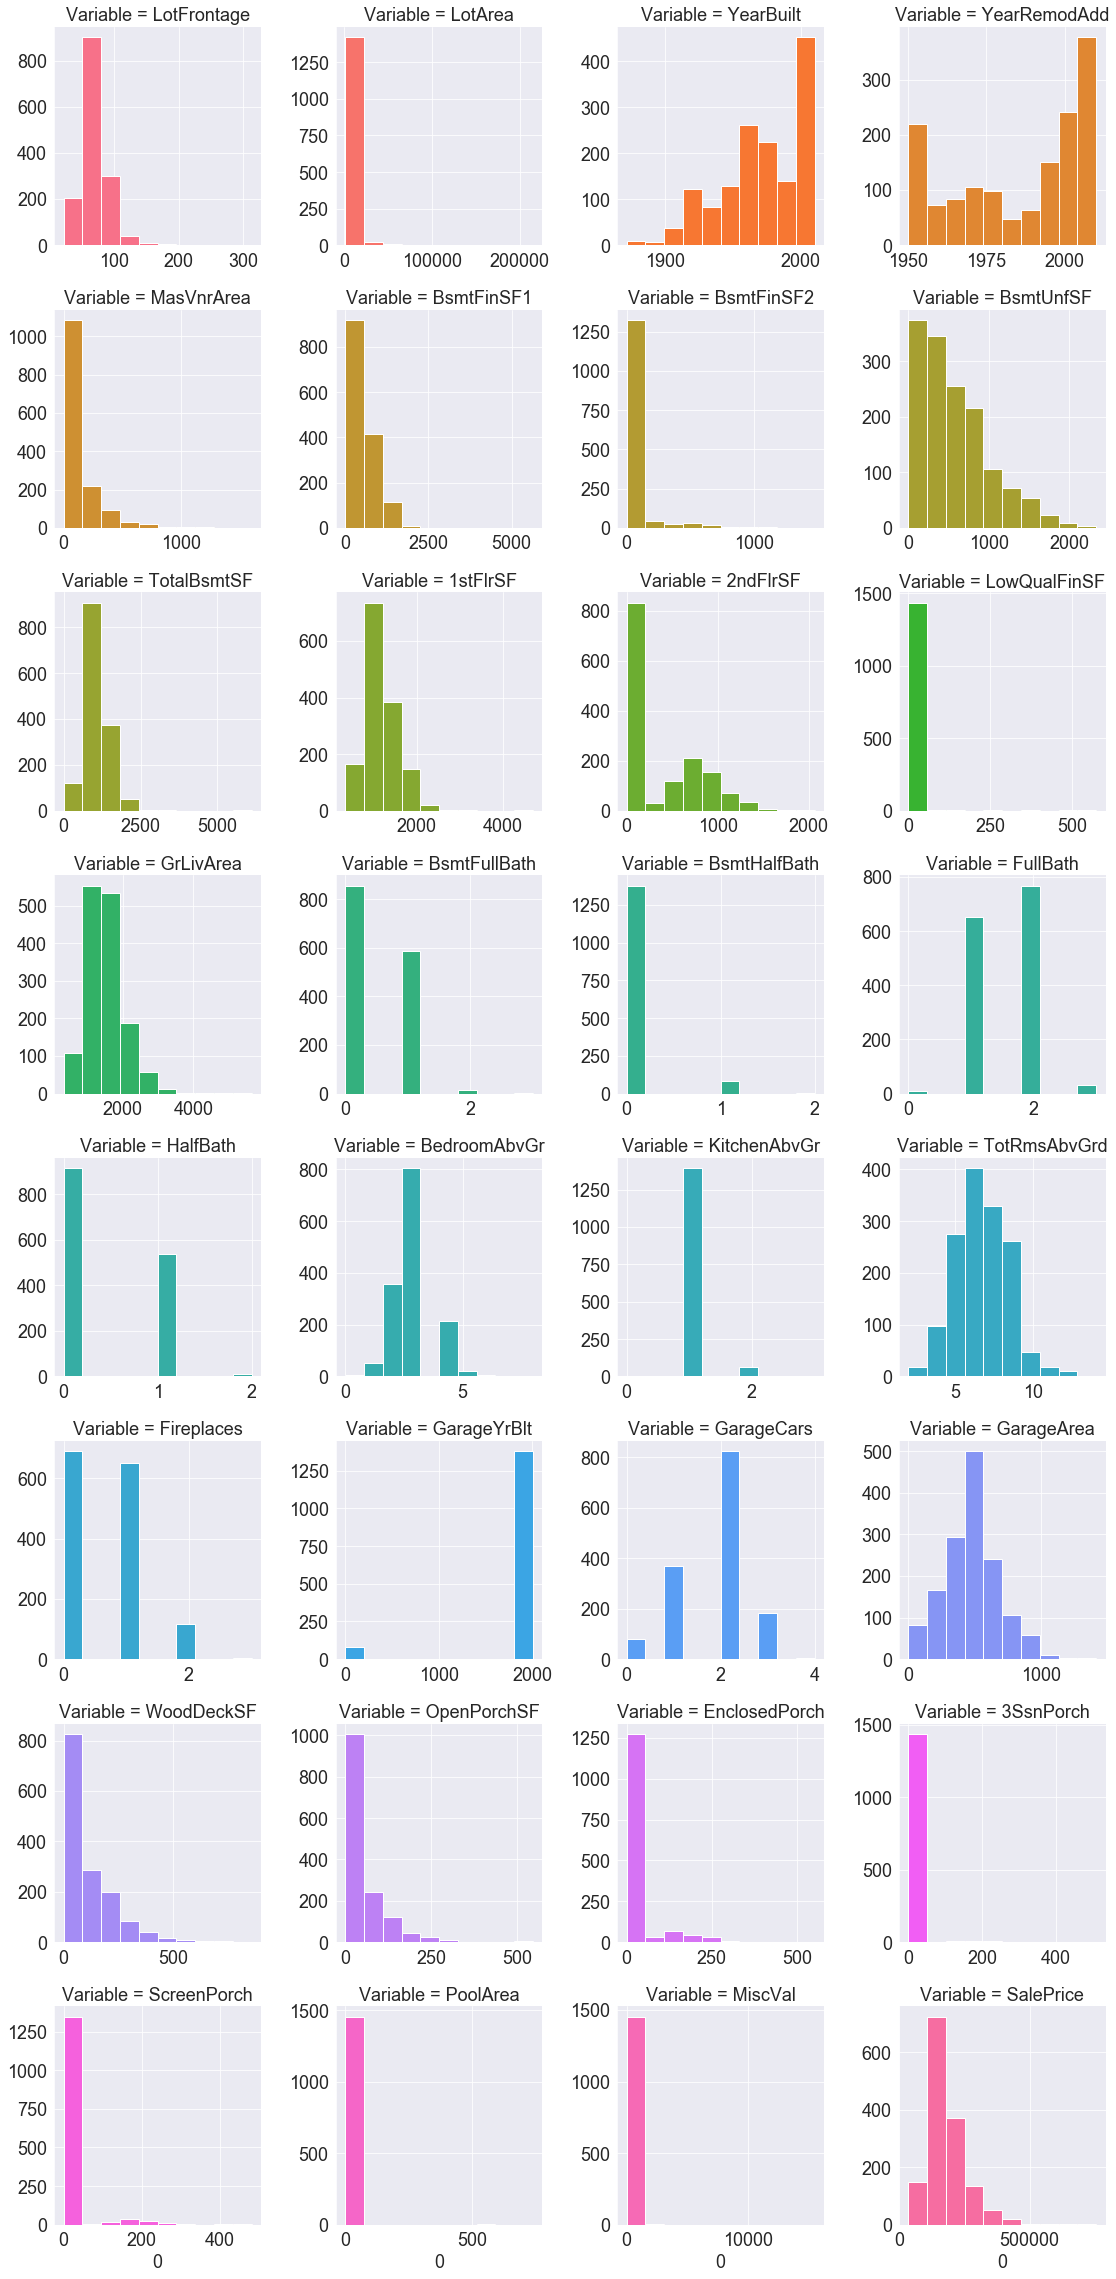

In [18]:
g = sns.FacetGrid(full_data.select_dtypes(np.number).stack().reset_index(1).rename({'level_1': 'Variable' ,0: '0'}, axis=1), col = 'Variable', col_wrap = 4, hue = 'Variable', sharex = False, sharey = False, height = 4)
g = g.map(plt.hist, '0')

Then we can apply a log one plus transformation to each of these variables and observe normalisation in many variables (most important of which is $\texttt{SalePrice}$).

In [19]:
for i in full_data.select_dtypes(np.number).columns:
    full_data[i] = np.log1p(full_data[i])

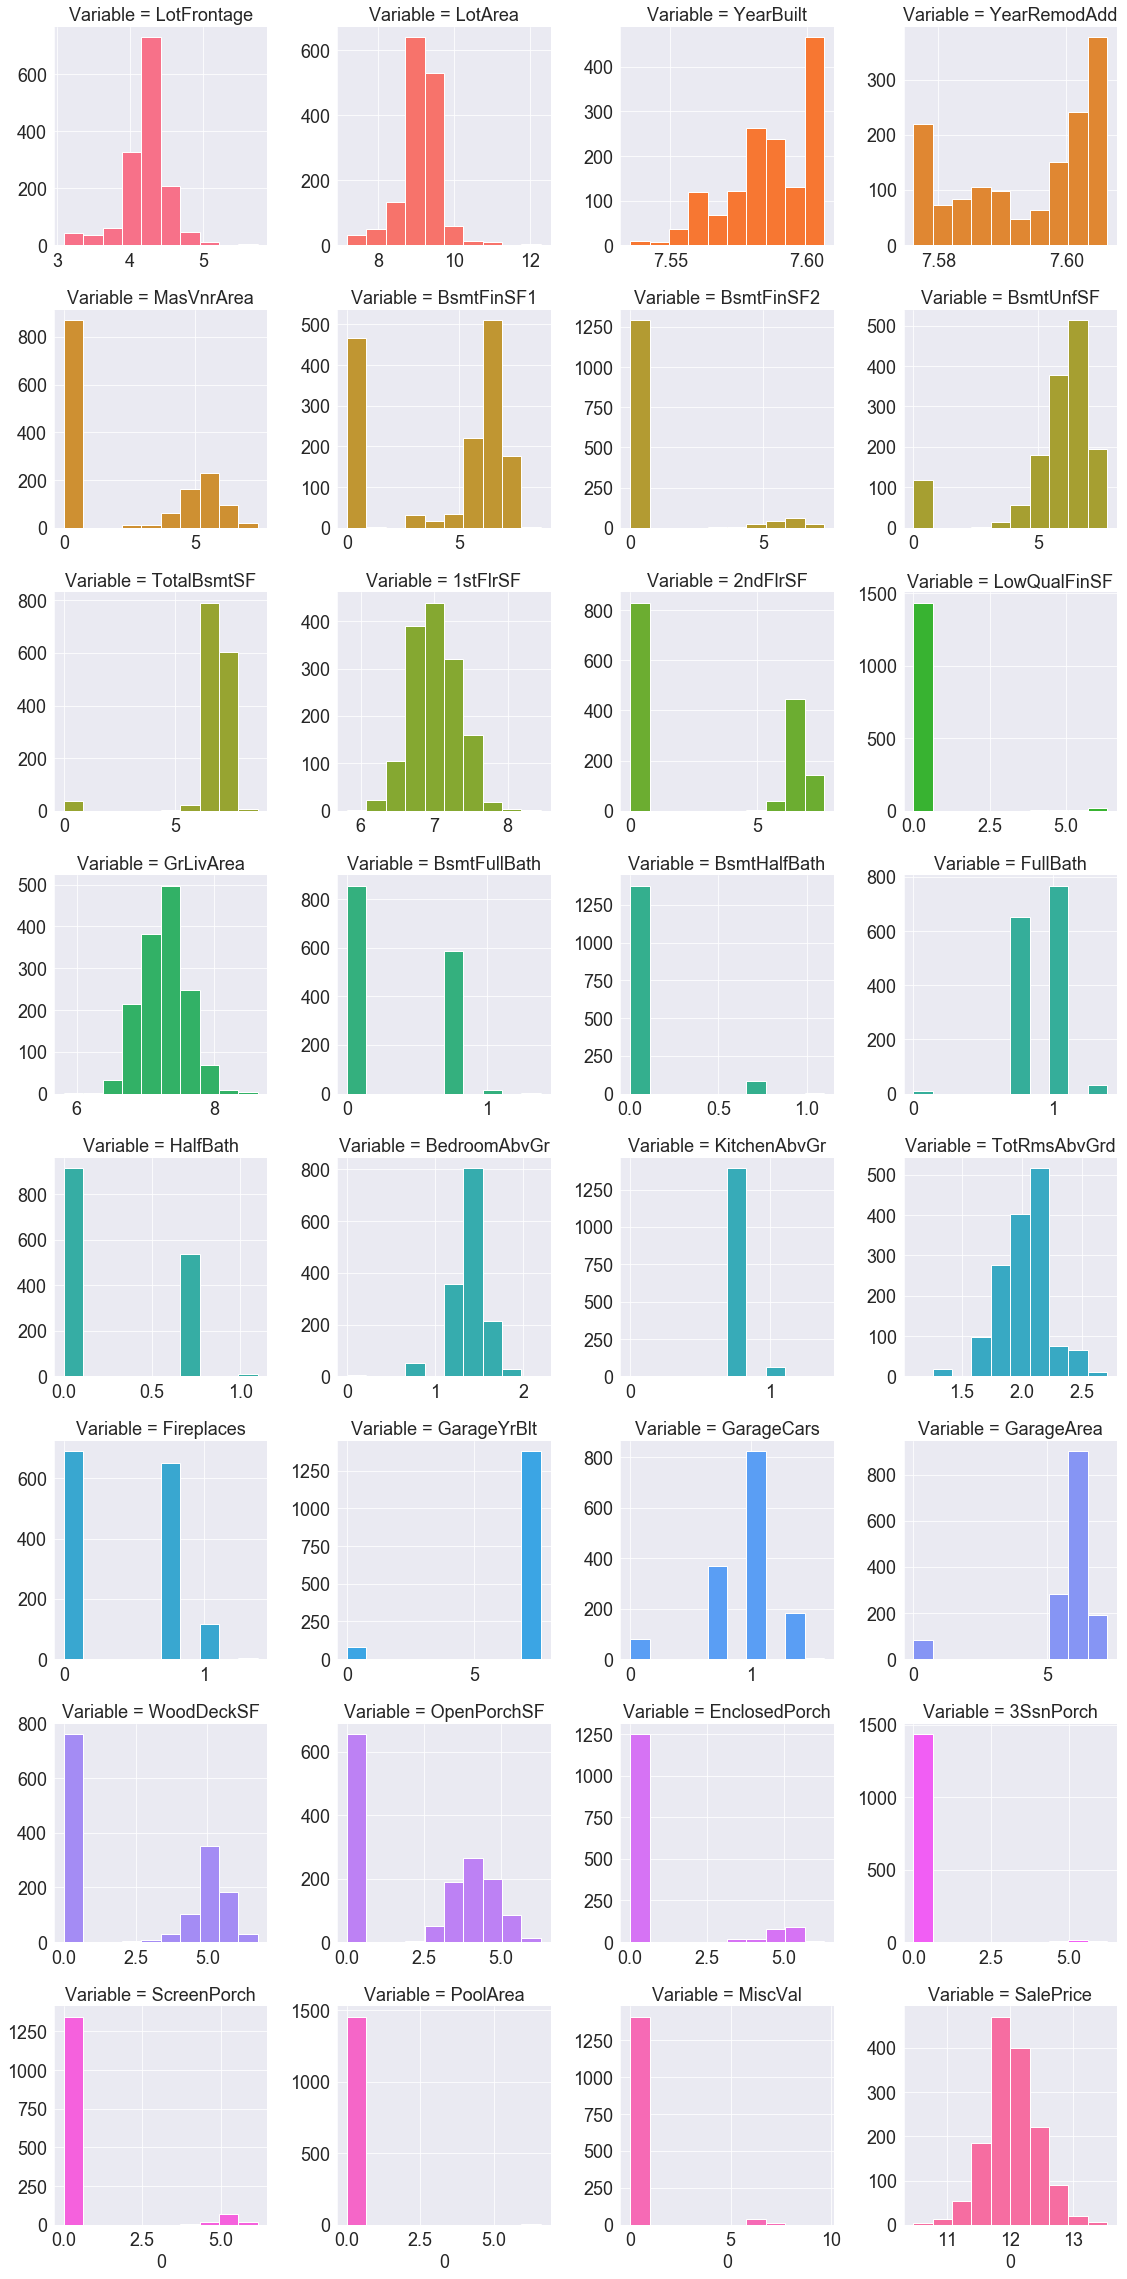

In [20]:
g = sns.FacetGrid(full_data.select_dtypes(np.number).stack().reset_index(1).rename({'level_1': 'Variable' ,0: '0'}, axis=1), col = 'Variable', col_wrap = 4, hue = 'Variable', sharex = False, sharey = False, height = 4)
g = g.map(plt.hist, '0')

Finally, the last change we can make to the data is to insert dummy variables for each level of each categorical variable. This will allow us to pass all of the given features into the chosen regression model and then we can allow the regression model itself to do the chosing of the most influence and important variables effecting the sale price. This adds a binary variable for each level of each category which determines if it has that level in that category which will increase the size of our dataframe greatly.

In [21]:
full_data = pd.get_dummies(full_data)
full_data.shape

(1460, 350)

Now we can split full_data into 70% training data and 30% validation data. As we are given that we require the first (not random) 70% of the data points to form the training set and the left over 30% to form the validation set we can slice the data in train.csv into two data frames. To do so we need to find how many data points are given in train.csv and then find approximately 70% of this total number.

In [22]:
full_data.shape

(1460, 350)

So we are given 1460 data points in total. So we can then find 70% of 1460.

In [23]:
slice_index = round(len(full_data)*0.7)
slice_index

1022

Then we can create our training data set and validation data set by splitting full_data by this found slice index.

In [24]:
training_data = full_data[:slice_index]
training_data.tail()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1017,4.248495,8.668196,7.593374,7.593374,0.000000,6.944087,0.0,5.220356,7.107425,7.215975,...,0,0,0,0,1,0,0,0,0,0
1018,4.248495,9.285912,7.596894,7.597396,4.343805,0.000000,0.0,5.953243,5.953243,6.688355,...,0,0,0,1,0,0,0,0,1,0
1019,3.784190,8.011023,7.603898,7.603898,4.983607,2.833213,0.0,7.205635,7.217443,7.317876,...,0,0,0,1,0,0,0,0,1,0
1020,4.110874,8.857230,7.603898,7.603898,0.000000,6.932448,0.0,4.691348,7.032624,7.032624,...,0,0,0,1,0,0,0,0,1,0
1021,4.174387,8.910181,7.604396,7.604396,4.442651,6.529419,0.0,6.246107,7.090077,7.107425,...,0,1,0,0,0,0,0,0,0,1


In [25]:
validation_data = full_data[slice_index:]
validation_data.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1022,3.970292,9.152711,7.565793,7.576097,0.000000,5.783825,0.000000,6.378426,6.816736,6.816736,...,0,0,0,1,0,0,0,0,1,0
1023,3.784190,8.065579,7.603898,7.604396,2.708050,2.833213,0.000000,7.193686,7.205635,7.316548,...,0,0,0,1,0,0,0,0,1,0
1024,4.248495,9.648531,7.589336,7.589336,0.000000,7.061334,5.993961,0.000000,7.356280,7.972121,...,0,0,0,0,1,0,0,0,0,0
1025,4.262680,8.949105,7.587311,7.587311,0.000000,4.934474,6.150603,5.624018,6.783325,6.783325,...,0,0,0,1,0,0,0,0,1,0
1026,4.304065,9.137877,7.581210,7.581210,5.783825,6.548219,0.000000,6.349139,7.145984,7.142827,...,0,0,0,1,0,0,0,0,1,0


Now we just need to train our chosen regression model on the training set and evaluate its accuracy on our validation set. I used the flowchart linked on [scikit-learn.org](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to help me select the best regression models to train on the data. I ended up training: Lasso, Elastic Net, Ridge Regression, SVR (both linear and rbf) and Gradient Boosting Regression on the data. The following code trains all of these models seperately on the data and outputs the root mean squared log error in predicting the sale price of the validation data.

In [26]:
from sklearn import linear_model
from sklearn import svm
from sklearn import kernel_ridge
from sklearn import ensemble
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import metrics

lasso = linear_model.Lasso(alpha = 1e-3)
elastic = linear_model.ElasticNet(alpha = 1e-3)
ridge = linear_model.Ridge()
svr_lin = svm.SVR(kernel = 'linear', gamma = 'auto')
svr_rbf = svm.SVR(kernel = 'rbf', gamma = 'auto')
gbr = ensemble.GradientBoostingRegressor(loss = 'huber')
names = ('lasso  ', 'elastic', 'ridge  ', 'svr_lin', 'svr_rbf', 'gbr    ')
models = (lasso, elastic, ridge, svr_lin, svr_rbf, gbr)

for i in range(len(models)):
    models[i].fit(X = training_data.drop('SalePrice', axis = 1), y = training_data.SalePrice)
    predicted = models[i].predict(validation_data.drop('SalePrice', axis = 1))
    print(names[i] + " : " + round(np.sqrt(metrics.mean_squared_error(y_true = np.log(np.expm1(validation_data.SalePrice)), y_pred = np.log(np.expm1(predicted)))), 5).astype(str))

lasso   : 0.13305
elastic : 0.13072
ridge   : 0.13501
svr_lin : 0.14694
svr_rbf : 0.14042
gbr     : 0.13074


So it seems that the best regression models for predicting the validation data were Lasso, Elastic Net and Gradient Boosting Regression.